# Reading the data

The very first step on Kaggle is to read the data. For brevity, I choose ``tr`` and ``te`` for the training and test set, respectively:

In [1]:
import pandas as pd


tr = pd.read_csv("../input/titanic/train.csv")
te = pd.read_csv("../input/titanic/test.csv")
print(tr.columns.to_list())
print(te.columns.to_list())

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


The label to be predicted is ``Survived``, which is missing in the test set. As a first step in the project, I try to create a baseline model—a reference to the performance I need to improve. In this case (and in most classification problems), I consider as a baseline the model that predicts the most common value for the label. Here,

In [2]:
from IPython.display import display
from IPython.display import Markdown


display(Markdown(tr["Survived"].value_counts().reset_index().to_markdown(index=False)))

|   index |   Survived |
|--------:|-----------:|
|       0 |        549 |
|       1 |        342 |

Thus, by predicting everyone died, I am right in a fraction 549/(549+342) of the cases, i.e., 62% of the time. As the metric for the problem is the accuracy, I start from a 62% of accuracy.

# Basic Data Cleaning

To be sure to perform cleaning in the same exact way for training and testing datasets, I merge them in a unique dataset, retaining the information of the source: 

In [3]:
tr["Source"] = "Training"
te["Source"] = "Testing"

df = pd.concat((tr, te))
print(df.shape)

(1309, 13)


I refactor the code ingestion in a unique function:

In [4]:
import pandas as pd


def ingest_data() -> pd.DataFrame():
    tr = pd.read_csv("../input/titanic/train.csv")
    te = pd.read_csv("../input/titanic/test.csv")

    tr["Source"] = "Training"
    te["Source"] = "Testing"

    return pd.concat((tr, te))


df = ingest_data()

Then, I start analyzing each of the original columns.

## Basic data exploration

I write in Markdown for convenience the columns and their types:

In [5]:
types = [str(i) for i in df.dtypes.values]

for i in range(df.shape[1]):
    print(f"* **{df.columns[i]}**: {types[i]}")

* **PassengerId**: int64
* **Survived**: float64
* **Pclass**: int64
* **Name**: object
* **Sex**: object
* **Age**: float64
* **SibSp**: int64
* **Parch**: int64
* **Ticket**: object
* **Fare**: float64
* **Cabin**: object
* **Embarked**: object
* **Source**: object


which is rendered to:

* **PassengerId**: int64
* **Survived**: float64
* **Pclass**: int64
* **Name**: object
* **Sex**: object
* **Age**: float64
* **SibSp**: int64
* **Parch**: int64
* **Ticket**: object
* **Fare**: float64
* **Cabin**: object
* **Embarked**: object
* **Source**: object

I analyze then the columns one by one.

## PassengerId

This is the identification number of the passenger; it houls not retain any relevant information. However, in some competition there could be some data leak, thus i could include it and later exclude it from considerarion while doing feature selection.
The type is integer, so no need for firther processing. 

There are no missing points:





In [6]:
import numpy as np

i = "PassengerId"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))

Percentage of null for PassengerId: 0.0


## Pclass

This column represent the ticket class. There are three possible values, and no missing values:

In [7]:
i = "Pclass"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))
print(df[i].unique())

Percentage of null for Pclass: 0.0
[3 1 2]


## Name

This represent the name of the passenger. Can not be used the way it is:

In [8]:
i = "Name"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))
print(df[i].unique()[:5])

Percentage of null for Name: 0.0
['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry']


## Sex

This represent the name of the passenger. Can not be used the way it is (it is an object):

In [9]:
i = "Sex"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))
print(df[i].unique()[:5])

Percentage of null for Sex: 0.0
['male' 'female']


Can be simply encoded:

In [10]:
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
print(df["Sex"].unique())

[0 1]


## Age

The age of the passenger. Quoting [the data notes](https://www.kaggle.com/competitions/titanic/data),

> Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

In [11]:
i = "Age"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))
print(df[i].unique()[:5])

Percentage of null for Age: 0.20091673032849502
[22. 38. 26. 35. nan]


While there are many possible strategies for imputing a column with missing values, here I choose the easiest approach, imputing with the median:

In [12]:
print(np.median(df["Age"].dropna()))
df["Age"] = df["Age"].fillna(np.median(df["Age"].dropna()))

28.0


## SibSp

This is the number of siblings/spouses aboard the Titanic.

In [13]:
i = "SibSp"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))
print(df[i].unique()[:5])

Percentage of null for SibSp: 0.0
[1 0 3 4 2]


## Parch

The number of parents/children aboard the Titanic.

In [14]:
i = "Parch"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))
print(df[i].unique()[:5])

Percentage of null for Parch: 0.0
[0 1 2 5 3]


## Ticket

The ticket number; can not be used in the current form.

In [15]:
i = "Ticket"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))
print(df[i].unique()[:5])

Percentage of null for Ticket: 0.0
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450']


## Fare

The passenger fame; still a socio-economic indicator.

In [16]:
i = "Fare"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))
print(df[i].unique()[:5])

Percentage of null for Fare: 0.0007639419404125286
[ 7.25   71.2833  7.925  53.1     8.05  ]


Here again, I impute with the median fare for simplicity:

In [17]:
print(np.median(df["Fare"].dropna()))
df["Fare"] = df["Fare"].fillna(np.median(df["Fare"].dropna()))

14.4542


## Cabin

The cabin number; probably irrelevant:

In [18]:
i = "Cabin"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))
print(df[i].unique()[:5])

Percentage of null for Cabin: 0.774637127578304
[nan 'C85' 'C123' 'E46' 'G6']


With some many missing points, it is probably better skipping. 

## Embarked

Port of embarcation.

In [19]:
i = "Embarked"
print(f"Percentage of null for {i}:", np.mean(df[i].isnull()))
print(df[i].unique()[:5])

Percentage of null for Embarked: 0.0015278838808250573
['S' 'C' 'Q' nan]


Has the variable is categorical, I impute it with the most common embarked port:

In [20]:
df[i].value_counts().reset_index()

,index,Embarked
0,S,914
1,C,270
2,Q,123


In [21]:
df["Embarked"] = df["Embarked"].fillna("S")

## Refactoring to a simple function

In [22]:
import numpy as np
import pandas as pd


def ingest_data() -> pd.DataFrame():
    tr = pd.read_csv("../input/titanic/train.csv")
    te = pd.read_csv("../input/titanic/test.csv")

    tr["Source"] = "Training"
    te["Source"] = "Testing"

    return pd.concat((tr, te))


def feature_engineering0(input_df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    to_be_dropped = ["Name", "Ticket", "Cabin", "Source"]
    source = input_df["Source"]
    df = input_df.drop(to_be_dropped, axis=1).copy()

    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    df["Age"] = df["Age"].fillna(np.median(df["Age"].dropna()))
    df["Fare"] = df["Fare"].fillna(np.median(df["Fare"].dropna()))
    df["Embarked"] = df["Embarked"].fillna("S")

    df = pd.get_dummies(df, dtype=np.int64)
    return (df[source == "Training"], df[source == "Testing"])


df = ingest_data()
train, test = feature_engineering0(df)

# Train a model and measure perfomance

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(random_state=2024)
Y = train.pop("Survived")
scores = cross_val_score(model, train, Y, cv=10)
print(np.mean(scores), "+/-", np.std(scores))

0.8249563046192259 +/- 0.04366214002255289


# Refactoring everything in a single script

0.8249563046192259 +/- 0.04366214002255289 



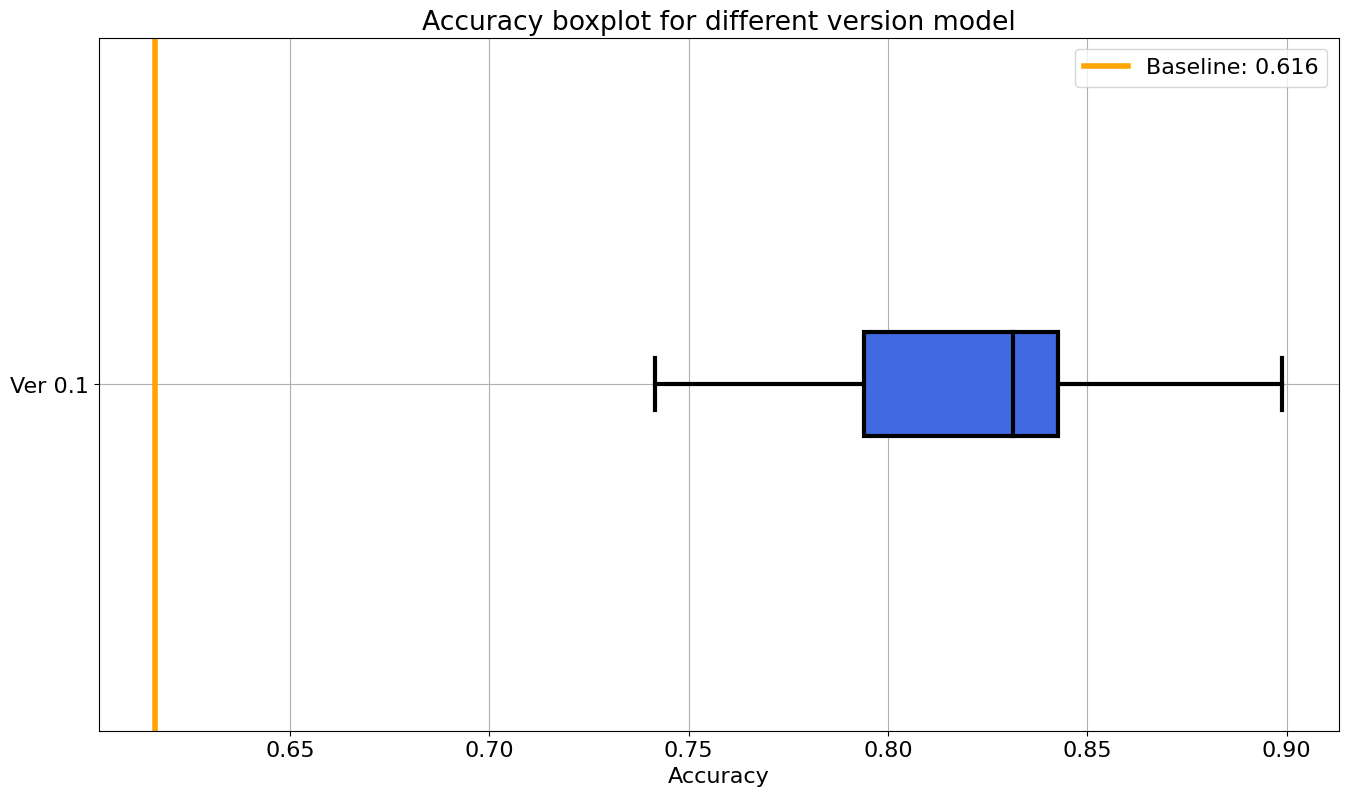

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


def ingest_data() -> pd.DataFrame():
    tr = pd.read_csv("../input/titanic/train.csv")
    te = pd.read_csv("../input/titanic/test.csv")

    tr["Source"] = "Training"
    te["Source"] = "Testing"

    return pd.concat((tr, te))


def feature_engineering0(input_df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    to_be_dropped = ["Name", "Ticket", "Cabin", "Source"]
    source = input_df["Source"]
    df = input_df.drop(to_be_dropped, axis=1).copy()

    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    df["Age"] = df["Age"].fillna(np.median(df["Age"].dropna()))
    df["Fare"] = df["Fare"].fillna(np.median(df["Fare"].dropna()))
    df["Embarked"] = df["Embarked"].fillna("S")

    df = pd.get_dummies(df, dtype=np.int64)
    return (df[source == "Training"], df[source == "Testing"])


def estimate_performance(train: pd.DataFrame) -> list:
    model = RandomForestClassifier(random_state=2024)
    Y = train.pop("Survived")
    scores = cross_val_score(model, train, Y, cv=10)
    print(np.mean(scores), "+/-", np.std(scores), "\n")
    return scores


version = 0.1
baseline = 549 / (549 + 342)

df = ingest_data()
train, test = feature_engineering0(df)
scores = estimate_performance(train)

performance = pd.DataFrame({"Version": [str(version)] * 10, "Performance": scores})
performance.to_csv(f"performance_{version}.csv", index=False)

p = {
    f"Ver {i}": performance.loc[performance["Version"] == i, "Performance"].to_list()
    for i in performance["Version"].unique()
}

plt.rcParams["font.size"] = 16
plt.figure(figsize=(16, 9))
plt.title("Accuracy boxplot for different version model")
plt.axvline(baseline, color="orange", lw=4, label=f"Baseline: {round(baseline, 3)}")
bp = plt.boxplot(
    performance["Performance"],
    vert=False,
    labels=p.keys(),
    patch_artist=True,
    boxprops=dict(facecolor="royalblue", color="black", linewidth=3),
    whiskerprops=dict(color="black", linewidth=3),
    capprops=dict(color="black", linewidth=3),
    medianprops=dict(color="black", linewidth=3),
)

plt.xlabel("Accuracy")
plt.grid()
plt.legend()
plt.savefig(f"Performance_{version}.png", dpi=300)